In [2]:
# Importing the necessary libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense,RandomRotation,RandomZoom,RandomFlip,RandomBrightness,Dropout,Input
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pathlib as Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

In [3]:
# Run only after copying the zip files in /content folder
!unzip Male.zip
!unzip Female.zip

Archive:  Male.zip
replace Male/Screenshot from 2024-05-17 23-27-03.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  Female.zip
replace Female/Screenshot from 2024-05-17 23-24-26.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
data_dir = Path.Path("/content/")
os.listdir(str(data_dir))

['.config',
 'Female.zip',
 'Male.zip',
 'model_weights.h5',
 'Male',
 'Female',
 'sample_data']

In [5]:
people_images_dict = {
    'male': list(data_dir.glob('Male/*')),
    'female': list(data_dir.glob('Female/*')),
}

In [6]:
people_label_dict = {
    'male': 0,
    'female': 1,
}

In [7]:
X, y = [], []
# Importing the images, converting them to arrays , resizing them so that all images are of same size, and adding labels for each image
for label, images in people_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(people_label_dict[label])

In [8]:
len(X)

208

In [9]:
X = np.array(X)
y = np.array(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.4)

In [11]:
X_train.shape,X_test.shape

((124, 180, 180, 3), (84, 180, 180, 3))

In [12]:
# Normalizing so that the values in img arrays are between 0 and 1.
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [13]:
X_train_scaled.shape

(124, 180, 180, 3)

Making a custom model


In [23]:
# Adding a data augmentation layer, so that there could be more variety of images in the training data and the model does not overfit.
data_aug_layer = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomZoom(0.4),
    RandomRotation(0.1),
])

In [25]:
# Trying to add more kernels and layers.
num_classes = 2

model2 = Sequential([
    data_aug_layer,
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.1),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [26]:
model2.fit(X_train_scaled, y_train, epochs=100,batch_size=16,validation_data=(X_test_scaled,y_test))       #It is overfitting

Epoch 1/100
8/8 [==============================] - 4s 73ms/step - loss: 1.0381 - accuracy: 0.5403 - val_loss: 0.6872 - val_accuracy: 0.6190
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 0.6640 - accuracy: 0.6613 - val_loss: 0.6793 - val_accuracy: 0.7262
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 0.6407 - accuracy: 0.7581 - val_loss: 0.6241 - val_accuracy: 0.7976
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 0.5858 - accuracy: 0.7016 - val_loss: 0.6166 - val_accuracy: 0.6310
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.5812 - accuracy: 0.6694 - val_loss: 0.5667 - val_accuracy: 0.6905
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 0.4897 - accuracy: 0.7742 - val_loss: 0.5808 - val_accuracy: 0.6905
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 0.4780 - accuracy: 0.7823 - val_loss: 0.4809 - val_accuracy: 0.8214
Epoch 8/100
8/8 [===

In [27]:
model_imagenet = InceptionV3(weights='imagenet',include_top=False,input_shape=(180, 180, 3))

In [28]:
model_imagenet.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 89, 89, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 89, 89, 32)           96        ['conv2d_14[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 89, 89, 32)           0         ['batch_normalizati

In [29]:
model_imagenet.trainable = False

In [34]:
# Adding a data augmentation layer, so that there could be more variety of images in the training data and the model does not overfit.
data_aug_layer = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomZoom(0.4),
    RandomRotation(0.1)
])

In [35]:
model = Sequential()
num_classes = 2
# Add the pre-trained base model
model.add(Input(shape=(180, 180, 3)))
model.add(data_aug_layer)
model.add(model_imagenet)
# Add custom layers on top
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes))  

from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [32]:
model.build()

In [ ]:
# Upload the saved weights (it takes time to upload the weights as it is a 224 mb file, to see the model in action you can checkout hugging face link)
model.load_weights("model_weights .h5")


In [38]:
# Uncomment if you have not loaded weights.
# model.fit(X_train_scaled, y_train, epochs=200,batch_size=16,validation_data=(X_test_scaled,y_test),callbacks=[early_stopping])

Epoch 1/200
8/8 [==============================] - 2s 222ms/step - loss: 0.0638 - accuracy: 0.9677 - val_loss: 0.4007 - val_accuracy: 0.9167
Epoch 2/200
8/8 [==============================] - 1s 95ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.4560 - val_accuracy: 0.9167
Epoch 3/200
8/8 [==============================] - 1s 67ms/step - loss: 0.0449 - accuracy: 0.9919 - val_loss: 0.4096 - val_accuracy: 0.9048
Epoch 4/200
8/8 [==============================] - 1s 86ms/step - loss: 0.0534 - accuracy: 0.9677 - val_loss: 0.5050 - val_accuracy: 0.9048
Epoch 5/200
8/8 [==============================] - 1s 87ms/step - loss: 0.0188 - accuracy: 0.9919 - val_loss: 0.4308 - val_accuracy: 0.8810
Epoch 6/200
8/8 [==============================] - 0s 65ms/step - loss: 0.0862 - accuracy: 0.9597 - val_loss: 0.5995 - val_accuracy: 0.8690
Epoch 7/200
8/8 [==============================] - 1s 86ms/step - loss: 0.0624 - accuracy: 0.9758 - val_loss: 0.5928 - val_accuracy: 0.8690
Epoch 8/200
8/8 [==

In [39]:
#Taking predictions
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.argmax(axis = 1)
y_preds_tensor = y_pred

3/3 [==============================] - 6s 1s/step


In [40]:
def is_equal(y_pred,y):
    if y_pred == y:
        return 1
    else:
        return 0


In [41]:
class_names = {
    1: 'female',
    0: 'male'
}

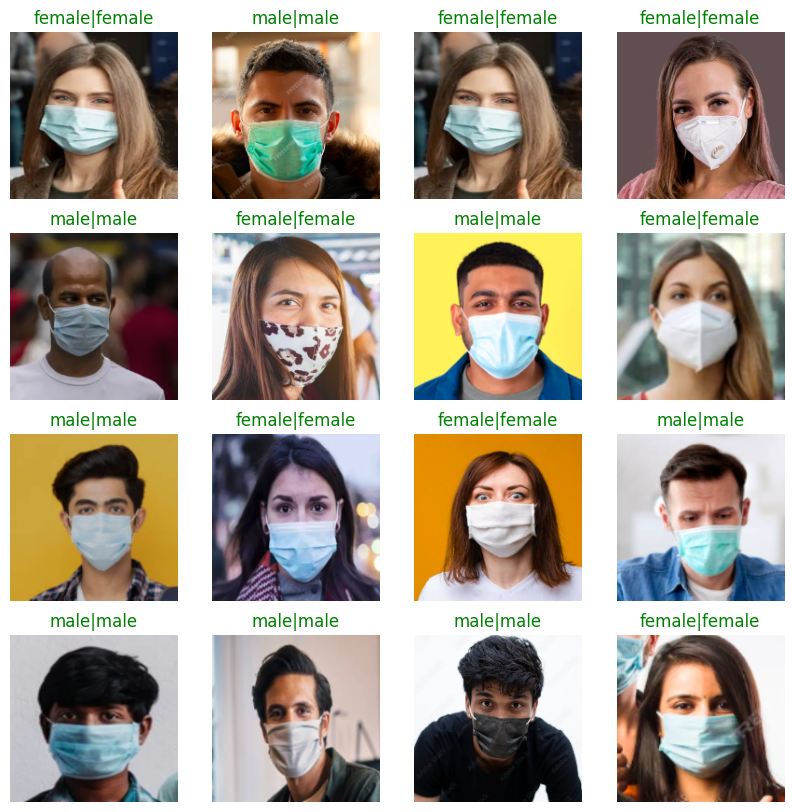

In [51]:
#Vissualizing result

No_of_values_to_predict = 16
plt.figure(figsize=(10,10))
Color = ['r','g']
list_indices = np.random.randint(0,len(X_test_scaled),16)
for x in range(16):
    plt.subplot(4,4,x+1)
    img = cv2.cvtColor(X_test_scaled[list_indices[x]].squeeze().astype(np.float32),cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{class_names[y_preds_tensor[list_indices[x]]]}|{class_names[y_test[list_indices[x]]]}",
          c=Color[is_equal(y_preds_tensor[list_indices[x]],y_test[list_indices[x]] )])

In [47]:
model.save_weights('/content/model_weights.h5')